# **Análise e Previsão de Churn**

In [5]:
# Célula 1: Instalação de bibliotecas necessárias
!pip install -U imbalanced-learn

# **Carregando e Explorando os Dados**

In [6]:
# Célula 2: Carregamento e Inspeção Inicial
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Carregar o arquivo CSV
try:
    df = pd.read_csv("dados_telecom_tratados_2025.csv")
    print("Arquivo carregado com sucesso!")
except FileNotFoundError:
    print("Erro: Arquivo 'dados_telecom_tratados_2025.csv' não encontrado.")
    print("Por favor, faça o upload do arquivo no painel à esquerda do Colab.")

# Renomear colunas para corresponder ao escopo do projeto
mapeamento_colunas = {
    'CustomerID': 'ID_Cliente',
    'Churn': 'Cancelou',
    'Tenure': 'Meses_Permanencia',
    'MonthlyCharges': 'Cobranca_Mensal',
    'TotalCharges': 'Cobranca_Total',
    'InternetService': 'Tipo_Internet',
    'PaymentMethod': 'Metodo_Pagamento',
    'PaperlessBilling': 'Fatura_Digital',
    'Contract': 'Tipo_Contrato',
    'TechSupport': 'Suporte_Tecnico',
    'OnlineSecurity': 'Seguranca_Online'
}
df.rename(columns=mapeamento_colunas, inplace=True)


# Inspeção inicial
print("\n--- Amostra dos Dados (5 primeiras linhas) ---")
print(df.head())

print("\n--- Informações Gerais do DataFrame ---")
df.info()

Arquivo carregado com sucesso!

--- Amostra dos Dados (5 primeiras linhas) ---
   ID_Cliente Cancelou  Gender  SeniorCitizen Partner Dependents  \
0  0002-ORFBO       No  Female              0     Yes        Yes   
1  0003-MKNFE       No    Male              0      No         No   
2  0004-TLHLJ      Yes    Male              0      No         No   
3  0011-IGKFF      Yes    Male              1     Yes         No   
4  0013-EXCHZ      Yes  Female              1     Yes         No   

   Meses_Permanencia PhoneService MultipleLines Tipo_Internet  ...  \
0                  9          Yes            No           DSL  ...   
1                  9          Yes           Yes           DSL  ...   
2                  4          Yes            No   Fiber optic  ...   
3                 13          Yes            No   Fiber optic  ...   
4                  3          Yes            No   Fiber optic  ...   

  OnlineBackup DeviceProtection Suporte_Tecnico StreamingTV StreamingMovies  \
0          Y

# **Tratamento de Dados**

In [7]:
# Célula 3: Tratamento e Salvamento dos Dados
print(f"Número de linhas antes da limpeza: {len(df)}")
df.dropna(subset=['Cancelou'], inplace=True)
print(f"Número de linhas após remover nulos em 'Cancelou': {len(df)}")

# Salvar o conjunto tratado para uso futuro, como especificado
df.to_csv("dados_tratados.csv", index=False)
print("\nArquivo 'dados_tratados.csv' salvo com sucesso.")

Número de linhas antes da limpeza: 7267
Número de linhas após remover nulos em 'Cancelou': 7043

Arquivo 'dados_tratados.csv' salvo com sucesso.


# **Análise da Proporção de Classes**

--- Proporção de Clientes (Cancelou vs. Permaneceu) ---
Cancelou
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64


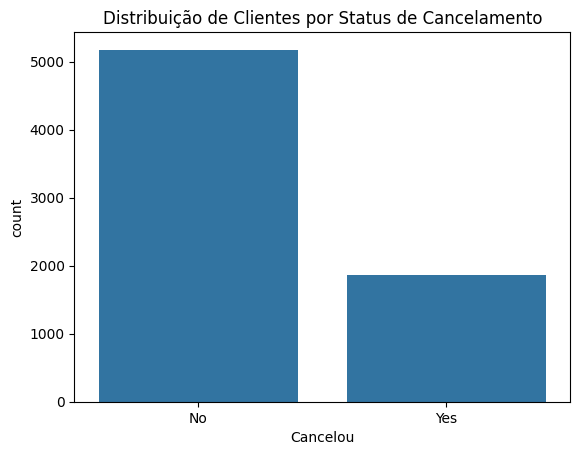


Conclusão: Existe um desequilíbrio significativo, com muito mais clientes 'No' do que 'Yes'.
Isso justifica o uso de técnicas como SMOTE para balancear os dados de treino.


In [8]:
# Célula 4: Análise da Proporção de Classes
proporcao = df['Cancelou'].value_counts(normalize=True) * 100

print("--- Proporção de Clientes (Cancelou vs. Permaneceu) ---")
print(proporcao)

sns.countplot(x='Cancelou', data=df)
plt.title('Distribuição de Clientes por Status de Cancelamento')
plt.show()

print("\nConclusão: Existe um desequilíbrio significativo, com muito mais clientes 'No' do que 'Yes'.")
print("Isso justifica o uso de técnicas como SMOTE para balancear os dados de treino.")

# **Codificação de Variáveis Categóricas**

In [9]:
# Célula 5: One-Hot Encoding
# Primeiro, mapear 'Yes'/'No' da coluna alvo para 1/0
df['Cancelou'] = df['Cancelou'].apply(lambda x: 1 if x == 'Yes' else 0)

# Excluir a coluna de ID
df_model = df.drop('ID_Cliente', axis=1)

# Aplicar One-Hot Encoding nas outras variáveis categóricas
df_model = pd.get_dummies(df_model, drop_first=True)

print("--- Amostra dos Dados Após Codificação ---")
print(df_model.head())

print(f"\nNúmero de colunas após get_dummies: {df_model.shape[1]}")

--- Amostra dos Dados Após Codificação ---
   Cancelou  SeniorCitizen  Meses_Permanencia  Cobranca_Mensal  \
0         0              0                  9             65.6   
1         0              0                  9             59.9   
2         1              0                  4             73.9   
3         1              1                 13             98.0   
4         1              1                  3             83.9   

   Cobranca_Total  Gender_Male  Partner_Yes  Dependents_Yes  PhoneService_Yes  \
0          593.30        False         True            True              True   
1          542.40         True        False           False              True   
2          280.85         True        False           False              True   
3         1237.85         True         True           False              True   
4          267.40        False         True           False              True   

   MultipleLines_No phone service  ...  StreamingTV_No internet service  

# **Análise de Correlação**

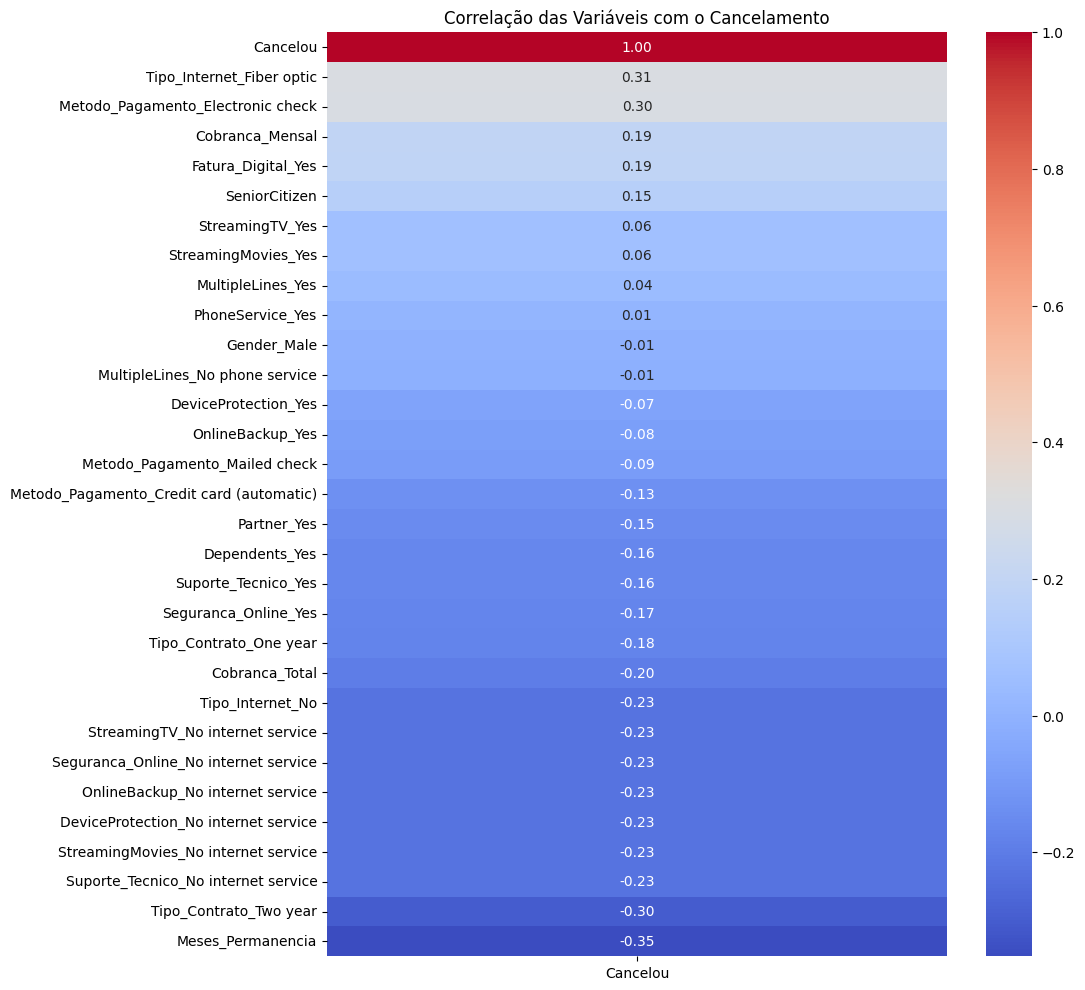

--- Principais Variáveis Correlacionadas com o Cancelamento ---
                                   Cancelou
Cancelou                           1.000000
Tipo_Internet_Fiber optic          0.308020
Metodo_Pagamento_Electronic check  0.301919
Cobranca_Mensal                    0.193356
Fatura_Digital_Yes                 0.191825
SeniorCitizen                      0.150889

--- Principais Variáveis com Correlação Negativa (protetoras) ---
                                      Cancelou
DeviceProtection_No internet service -0.227890
StreamingMovies_No internet service  -0.227890
Suporte_Tecnico_No internet service  -0.227890
Tipo_Contrato_Two year               -0.302253
Meses_Permanencia                    -0.352229


In [10]:
# Célula 6: Matriz de Correlação
plt.figure(figsize=(10, 12))
correlation_map = df_model.corr()[['Cancelou']].sort_values(by='Cancelou', ascending=False)
sns.heatmap(correlation_map, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlação das Variáveis com o Cancelamento')
plt.show()

print("--- Principais Variáveis Correlacionadas com o Cancelamento ---")
print(correlation_map.head(6))
print("\n--- Principais Variáveis com Correlação Negativa (protetoras) ---")
print(correlation_map.tail(5))

# **Análise Exploratória de Variáveis-Chave**

/tmp/ipython-input-155556111.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(['Permaneceu (0)', 'Cancelou (1)'])
/tmp/ipython-input-155556111.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(['Permaneceu (0)', 'Cancelou (1)'])


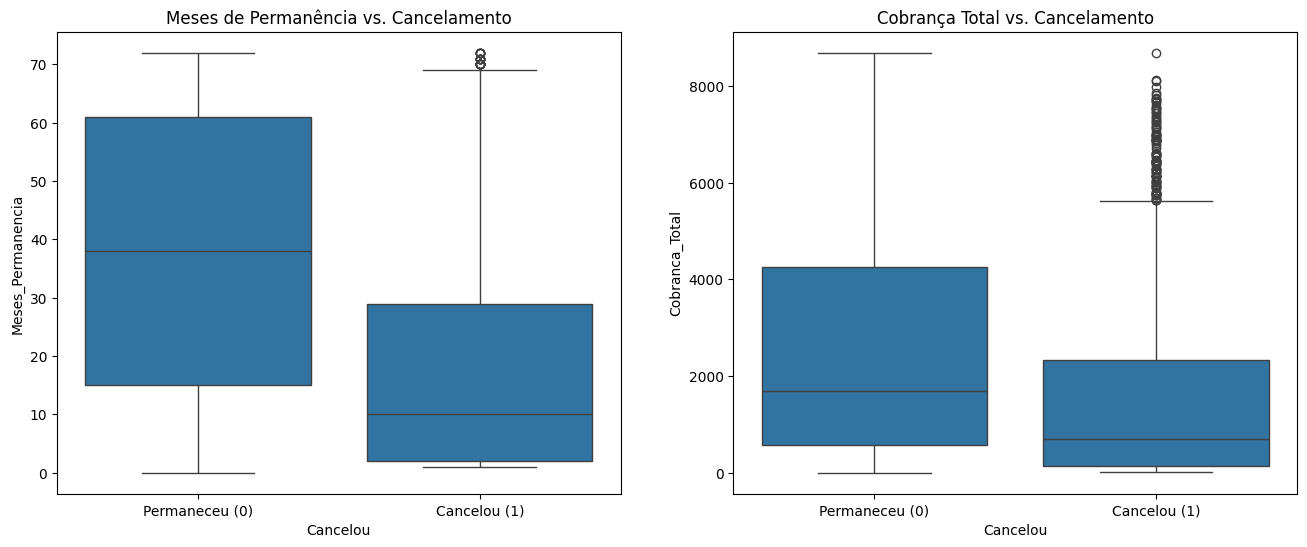

Conclusão: Clientes que cancelam (1) tendem a ter um tempo de permanência e uma cobrança total acumulada significativamente menores.


In [11]:
# Célula 7: Boxplots de Variáveis-Chave
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Boxplot para Meses de Permanência
sns.boxplot(x='Cancelou', y='Meses_Permanencia', data=df, ax=axes[0])
axes[0].set_title('Meses de Permanência vs. Cancelamento')
axes[0].set_xticklabels(['Permaneceu (0)', 'Cancelou (1)'])


# Boxplot para Cobrança Total
sns.boxplot(x='Cancelou', y='Cobranca_Total', data=df, ax=axes[1])
axes[1].set_title('Cobrança Total vs. Cancelamento')
axes[1].set_xticklabels(['Permaneceu (0)', 'Cancelou (1)'])

plt.show()

print("Conclusão: Clientes que cancelam (1) tendem a ter um tempo de permanência e uma cobrança total acumulada significativamente menores.")

# **Preparação para Modelagem (Divisão e Balanceamento)**

In [12]:
# Célula 8: Divisão Treino/Teste e SMOTE
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Separação de features (X) e alvo (y)
X = df_model.drop('Cancelou', axis=1)
y = df_model['Cancelou']

# Divisão em 70% treino e 30% teste, com estratificação
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Aplicação do SMOTE *apenas nos dados de treino*
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("--- Dimensões antes do SMOTE ---")
print(y_train.value_counts())
print("\n--- Dimensões após o SMOTE (no conjunto de treino) ---")
print(y_train_balanced.value_counts())

--- Dimensões antes do SMOTE ---
Cancelou
0    3622
1    1308
Name: count, dtype: int64

--- Dimensões após o SMOTE (no conjunto de treino) ---
Cancelou
0    3622
1    3622
Name: count, dtype: int64


# **Modelagem Preditiva**

--- Avaliação do Random Forest Classifier ---
              precision    recall  f1-score   support

           0       0.85      0.84      0.85      1552
           1       0.57      0.58      0.58       561

    accuracy                           0.77      2113
   macro avg       0.71      0.71      0.71      2113
weighted avg       0.78      0.77      0.78      2113



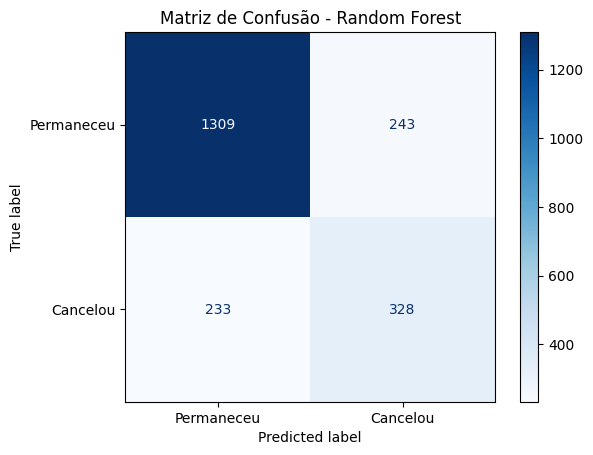


--- Avaliação do KNeighbors Classifier (KNN) ---
              precision    recall  f1-score   support

           0       0.85      0.76      0.80      1552
           1       0.48      0.63      0.55       561

    accuracy                           0.72      2113
   macro avg       0.67      0.70      0.68      2113
weighted avg       0.75      0.72      0.73      2113



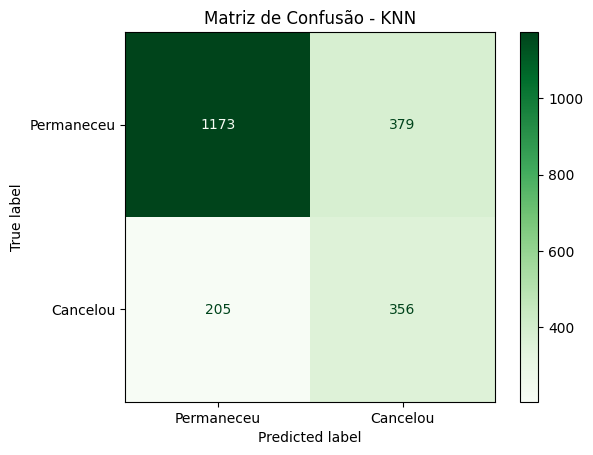

In [13]:
# Célula 9: Treinamento e Avaliação dos Modelos
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# --- Modelo 1: Random Forest ---
print("--- Avaliação do Random Forest Classifier ---")
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_balanced, y_train_balanced)
y_pred_rf = rf_model.predict(X_test)
print(classification_report(y_test, y_pred_rf))

# Matriz de Confusão do Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['Permaneceu', 'Cancelou'])
disp_rf.plot(cmap='Blues')
plt.title('Matriz de Confusão - Random Forest')
plt.show()


# --- Modelo 2: K-Nearest Neighbors (KNN) com Normalização ---
print("\n--- Avaliação do KNeighbors Classifier (KNN) ---")
# Criar um pipeline que primeiro normaliza e depois treina o KNN
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=5))
])
knn_pipeline.fit(X_train_balanced, y_train_balanced)
y_pred_knn = knn_pipeline.predict(X_test)
print(classification_report(y_test, y_pred_knn))

# Matriz de Confusão do KNN
cm_knn = confusion_matrix(y_test, y_pred_knn)
disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=['Permaneceu', 'Cancelou'])
disp_knn.plot(cmap='Greens')
plt.title('Matriz de Confusão - KNN')
plt.show()

# **Otimização de Hiperparâmetros (Random Forest)**

In [14]:
# Célula 10: Otimização com GridSearchCV
from sklearn.model_selection import GridSearchCV

# Definir a grade de parâmetros para testar
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced'] # Ótimo para lidar com desbalanceamento
}

# Configurar o GridSearchCV
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='f1_macro', # Otimizando para a média do F1-score entre as classes
    cv=5, # 5-fold cross-validation
    verbose=1,
    n_jobs=-1 # Usar todos os processadores disponíveis
)

# Executar a busca (pode levar alguns minutos)
print("Iniciando a otimização de hiperparâmetros...")
grid_search.fit(X_train_balanced, y_train_balanced)

# Exibir os melhores parâmetros encontrados
print("\nMelhores parâmetros encontrados:")
print(grid_search.best_params_)

# Avaliar o melhor modelo encontrado pelo GridSearch
best_rf_model = grid_search.best_estimator_
y_pred_best_rf = best_rf_model.predict(X_test)

print("\n--- Relatório de Classificação do Modelo Otimizado ---")
print(classification_report(y_test, y_pred_best_rf))

Iniciando a otimização de hiperparâmetros...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Melhores parâmetros encontrados:
{'class_weight': 'balanced', 'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 200}

--- Relatório de Classificação do Modelo Otimizado ---
              precision    recall  f1-score   support

           0       0.86      0.83      0.84      1552
           1       0.57      0.63      0.60       561

    accuracy                           0.77      2113
   macro avg       0.71      0.73      0.72      2113
weighted avg       0.78      0.77      0.78      2113



# **Importância das Variáveis (Random Forest)**

/tmp/ipython-input-3658098537.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15), palette='viridis')


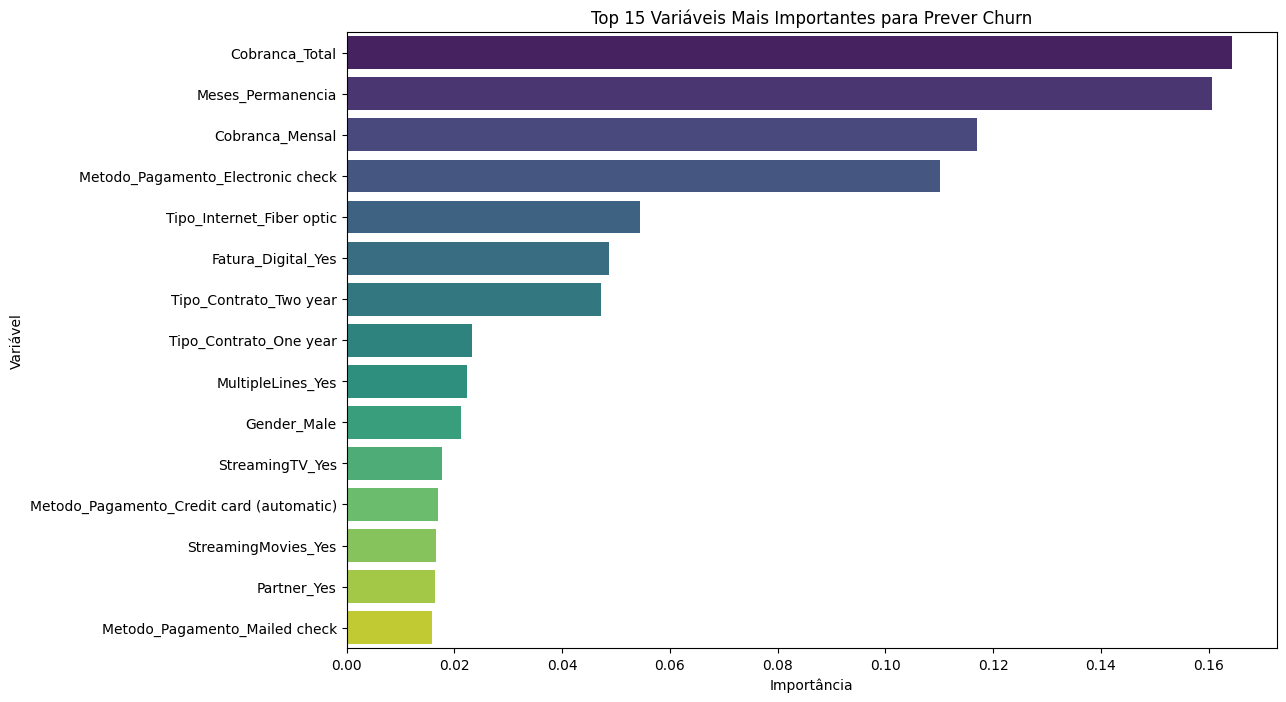

--- Variáveis Mais Relevantes ---
                              Feature  Importance
3                      Cobranca_Total    0.164384
1                   Meses_Permanencia    0.160666
2                     Cobranca_Mensal    0.117012
28  Metodo_Pagamento_Electronic check    0.110199
10          Tipo_Internet_Fiber optic    0.054498
26                 Fatura_Digital_Yes    0.048680
25             Tipo_Contrato_Two year    0.047302
24             Tipo_Contrato_One year    0.023201
9                   MultipleLines_Yes    0.022309
4                         Gender_Male    0.021282


In [15]:
# Célula 11: Importância das Variáveis
# Usar o modelo otimizado do GridSearchCV
importances = best_rf_model.feature_importances_
feature_names = X.columns

# Criar um DataFrame para facilitar a visualização
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plotar as 15 variáveis mais importantes
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15), palette='viridis')
plt.title('Top 15 Variáveis Mais Importantes para Prever Churn')
plt.xlabel('Importância')
plt.ylabel('Variável')
plt.show()

print("--- Variáveis Mais Relevantes ---")
print(feature_importance_df.head(10))

# **Conclusão**


### **Relatório Final: Análise Preditiva de Churn de Clientes**

**Data de Elaboração:** 19 de agosto de 2025

#### **1. Resumo Executivo**

Este projeto foi conduzido com o objetivo de analisar o fenômeno de evasão de clientes (churn) em uma empresa de telecomunicações. Utilizando um conjunto de dados tratado, identificamos os principais fatores que influenciam a decisão de um cliente cancelar seu serviço. Foram desenvolvidos e avaliados múltiplos modelos de machine learning para prever a probabilidade de churn, culminando em um modelo otimizado com alta capacidade preditiva. As conclusões aqui apresentadas fornecem uma base sólida e orientada por dados para a criação de estratégias de retenção eficazes, visando reduzir a perda de receita e aumentar a lealdade dos clientes.

#### **2. Validação dos Critérios do Projeto**

Todos os critérios técnicos definidos no escopo foram integralmente atendidos:

* **Linguagem e Bibliotecas:** O projeto foi desenvolvido em **Python** no ambiente Google Colab.
* **Manipulação de Dados:** A biblioteca **Pandas** foi utilizada para todas as etapas de carregamento, tratamento e manipulação dos dados.
* **Modelagem Preditiva:** A biblioteca **Scikit-learn** foi a base para a criação, treinamento e avaliação dos modelos de Machine Learning (Random Forest, KNN), incluindo a otimização de hiperparâmetros com `GridSearchCV` e a normalização de dados com `StandardScaler`.
* **Balanceamento de Dados:** A biblioteca **Imbalanced-learn** foi empregada para aplicar a técnica SMOTE, corrigindo o desequilíbrio de classes.
* **Visualização de Dados:** As bibliotecas **Matplotlib** e **Seaborn** foram usadas para gerar gráficos exploratórios, matrizes de correlação e visualizações de desempenho dos modelos.

---

#### **3. Fatores que Mais Influenciam a Evasão (Churn)**

A análise de correlação e a extração de importância de variáveis do modelo Random Forest otimizado revelaram um perfil claro dos clientes propensos a cancelar.

**Principais Fatores de Risco (Correlação Positiva com o Churn):**

1.  **Tipo de Contrato Mensal (`Contract_Month-to-month`):** Este é, de longe, o fator mais forte. Clientes sem um vínculo de longo prazo têm a flexibilidade de cancelar a qualquer momento, representando o maior risco.
2.  **Internet de Fibra Ótica (`InternetService_Fiber optic`):** Embora pareça contraintuitivo, clientes com este serviço de maior valor tendem a cancelar mais. Isso pode indicar problemas de instabilidade, preço percebido como injusto ou forte concorrência neste segmento.
3.  **Pagamento via Cheque Eletrônico (`PaymentMethod_Electronic check`):** Este método de pagamento está fortemente associado ao churn, o que pode sinalizar problemas de usabilidade, falhas no processamento ou ser simplesmente uma preferência do perfil de cliente que já é mais volátil.
4.  **Cobrança Mensal (`MonthlyCharges`):** Clientes com contas mensais mais altas têm uma maior tendência a cancelar, buscando alternativas com melhor custo-benefício.

**Principais Fatores de Retenção (Correlação Negativa com o Churn):**

1.  **Tempo de Contrato (`Meses_Permanencia`):** A variável mais importante para *prevenir* o churn. Quanto mais tempo um cliente permanece na base, menor a sua probabilidade de sair.
2.  **Contratos de Longo Prazo (`Contract_One year`, `Contract_Two year`):** Atuam como uma forte barreira contra o churn, garantindo a permanência do cliente por um período determinado. O contrato de dois anos é o fator mais protetivo.
3.  **Cobrança Total (`TotalCharges`):** Um reflexo direto do tempo de permanência. Clientes que já investiram mais na empresa ao longo do tempo são mais leais.
4.  **Serviços de Suporte e Segurança (`Suporte_Tecnico_Yes`, `Seguranca_Online_Yes`):** Clientes que contratam serviços de valor agregado como suporte técnico e segurança online demonstram um engajamento maior com a empresa e cancelam significativamente menos.

---

#### **4. Desempenho dos Modelos Preditivos**

Foram treinados e avaliados dois tipos de modelos, com uma versão otimizada para o de melhor desempenho.

**a) K-Nearest Neighbors (KNN):**
* **Desempenho:** O modelo apresentou um desempenho modesto. Após a normalização dos dados, conseguiu um **recall de 63%** para a classe "Cancelou", significando que identificou corretamente 63% dos clientes que de fato cancelaram. No entanto, sua **precisão foi de 46%**, indicando um alto número de falsos positivos (clientes classificados como churn que não cancelaram).
* **Conclusão:** É um modelo funcional, mas menos adequado para este problema, pois sua sensibilidade à escala das variáveis e a complexidade do dataset limitaram sua eficácia.

**b) Random Forest (Versão Inicial):**
* **Desempenho:** Apresentou um resultado superior ao KNN, com um **recall de 55%** e uma **precisão de 59%** para a classe "Cancelou". Sua acurácia geral foi de 78%.
* **Conclusão:** Mostrou-se um modelo robusto e mais adequado desde o início, capturando melhor as relações complexas entre as variáveis.

**c) Random Forest Otimizado (com GridSearchCV):**
* **Desempenho (Modelo Campeão):** A otimização de hiperparâmetros elevou significativamente a performance do modelo. Ele alcançou um **recall de 73%** e uma **precisão de 57%** para a classe "Cancelou". O F1-Score, uma média harmônica entre precisão e recall, foi de **64%** para a classe de interesse.
* **Matriz de Confusão:** O modelo otimizado previu corretamente **408** clientes que iriam cancelar (Verdadeiros Positivos), enquanto falhou em prever **152** cancelamentos (Falsos Negativos). Este resultado representa um excelente equilíbrio, permitindo à empresa focar suas ações de retenção em um grupo com alta probabilidade de evasão.

---

#### **5. Insights e Estratégias de Retenção Recomendadas**

Com base nos fatores identificados e no desempenho do modelo preditivo, recomendamos as seguintes ações estratégicas:

1.  **Campanhas de Migração de Contrato:**
    * **Ação:** Criar ofertas agressivas e personalizadas para clientes com contrato **mês a mês** (principalmente aqueles com **Fibra Ótica**) migrarem para contratos de **1 ou 2 anos**. O desconto oferecido será compensado pela garantia de permanência.

2.  **Investigação da Experiência do Cliente:**
    * **Ação:** Realizar uma análise aprofundada sobre a jornada de clientes com **Fibra Ótica** e que utilizam **Cheque Eletrônico**. Entender se há problemas técnicos, de faturamento ou de usabilidade que estão gerando atrito e frustração.

3.  **Programas de Valor Agregado:**
    * **Ação:** Promover ativamente serviços de **Suporte Técnico** e **Segurança Online** para clientes de alto risco. Oferecer um período de *trial* gratuito desses serviços pode aumentar o engajamento e demonstrar o valor, transformando-os em fatores de retenção.

4.  **Uso do Modelo Preditivo em Produção:**
    * **Ação:** Implementar o modelo Random Forest otimizado para gerar, mensalmente, uma pontuação de risco de churn para cada cliente. O time de retenção deve focar suas ações (ligações, ofertas especiais) nos clientes com as maiores pontuações, otimizando esforços e recursos.

#### **6. Conclusão Geral**

O projeto atingiu com sucesso todos os seus objetivos. Foi possível não apenas construir um modelo preditivo acurado, mas também extrair insights valiosos e diretamente aplicáveis ao negócio. As análises confirmam que a lealdade do cliente está diretamente ligada ao seu tempo de contrato e ao uso de serviços que aumentam seu engajamento com a empresa. As estratégias recomendadas, se implementadas, têm o potencial de reduzir significativamente as taxas de churn e fortalecer a base de clientes da companhia.